# Imports:

In [1]:
import pandas as pd
from yahoo_fin import stock_info as si
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
def load_data(ticker):
    
        # see if ticker is already a loaded stock from yahoo finance
        if isinstance(ticker, str):
            #load it from yahoo_fin library
            df = si.get_data(ticker)
        elif isinstance(ticker, pd.DataFrame):
            #already loaded, use it directly
            df = ticker
        else:
            raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
        
        df.dropna(inplace=True)
        return df

In [4]:

data_stock = load_data("BSE")

In [5]:
data_stock = data_stock["2009-01-02":"2020-12-3"]

In [6]:
data_stock.head()

,open,high,low,close,adjclose,volume,ticker
2009-01-02,9.17,9.64,9.17,9.62,5.162783,4350.0,BSE
2009-01-05,9.62,10.03,9.60,10.03,5.382814,21828.0,BSE
2009-01-06,10.23,10.65,10.23,10.60,5.688720,33708.0,BSE
2009-01-07,10.57,10.75,10.40,10.70,5.742384,21600.0,BSE
2009-01-08,10.55,11.29,10.55,11.29,6.059023,11012.0,BSE


In [7]:
data_news = pd.read_csv("sentiment.csv" , index_col=0)

In [8]:
 # Converting the index as date
data_news.index = pd.to_datetime(data_news.index)

In [9]:
data_news.head()

,neg,neu,pos,compound,sentiment
publish_date,,,,,
2001-01-02,0.108,0.820,0.072,-0.9426,negative
2001-01-03,0.084,0.817,0.098,0.6322,positive
2001-01-04,0.083,0.844,0.073,-0.5468,negative
2001-01-05,0.103,0.740,0.157,0.9892,positive
2001-01-06,0.118,0.709,0.172,0.4404,positive


In [10]:
data_news = data_news["2009-01-02":"2020-12-3"]

In [11]:
adj = pd.DataFrame(data_stock.adjclose , index = data_stock.index)

In [12]:
adj

,adjclose
2009-01-02,5.162783
2009-01-05,5.382814
2009-01-06,5.688720
2009-01-07,5.742384
2009-01-08,6.059023
...,...
2020-11-27,13.341542
2020-11-30,13.320793
2020-12-01,13.301023
2020-12-02,13.330385


In [13]:
sentiment = pd.DataFrame(data_news.sentiment , index = data_news.index)

In [14]:
final_data = pd.concat([adj , sentiment] , join="inner" , axis=1 )

In [15]:
final_data

,adjclose,sentiment
2009-01-02,5.162783,negative
2009-01-05,5.382814,negative
2009-01-06,5.688720,negative
2009-01-07,5.742384,negative
2009-01-08,6.059023,negative
...,...,...
2020-11-27,13.341542,negative
2020-11-30,13.320793,negative
2020-12-01,13.301023,negative
2020-12-02,13.330385,negative


In [16]:
final_data.sentiment = final_data.sentiment.map({"negative":0,"positive":1})

In [17]:
final_data.head()

,adjclose,sentiment
2009-01-02,5.162783,0
2009-01-05,5.382814,0
2009-01-06,5.688720,0
2009-01-07,5.742384,0
2009-01-08,6.059023,0


In [18]:
final_data.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2020-11-19', '2020-11-20', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-27', '2020-11-30', '2020-12-01',
               '2020-12-02', '2020-12-03'],
              dtype='datetime64[ns]', length=3002, freq=None)

In [19]:
def preprocess(data):
    training_date = "2019-12-31"
    train_data,test_data = data.loc["2009-01-02":"2019-12-31" , :],data.loc["2020-01-02": , :]
    return train_data,test_data
    

In [20]:
 train_data,test_data = preprocess(final_data)

In [21]:
train_data.shape

(2768, 2)

In [22]:
#convert an array of values into a dataset matrix
def create_dataset(dataset , time_step=1):
    dataset = np.array(dataset)
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),:]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX) , np.array(dataY)

In [23]:
time_step=100
X_train , y_train = create_dataset(train_data , time_step)
X_test , ytest = create_dataset(test_data , time_step)

In [24]:
ytest.shape

(133,)

In [25]:
X_train.shape

(2667, 100, 2)

In [26]:
#reshape input to be [samples , time steps , features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],2)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],2) 

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,2)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51,051
Trainable params: 51,051
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
42/42 [==============================] - 8s 102ms/step - loss: 33.5704 - val_loss: 21.2291
Epoch 2/100
42/42 [==============================] - 3s 74ms/step - loss: 3.2816 - val_loss: 9.2821
Epoch 3/100
42/42 [==============================] - 3s 73ms/step - loss: 2.3592 - val_loss: 7.8236
Epoch 4/100
42/42 [==============================] - 3s 74ms/step - loss: 2.3388 - val_loss: 7.7472
Epoch 5/100
42/42 [==============================] - 3s 73ms/step - loss: 2.3192 - val_loss: 7.7161
Epoch 6/100
42/42 [==============================] - 3s 74ms/step - loss: 2.2903 - val_loss: 7.6732
Epoch 7/100
42/42 [==============================] - 3s 74ms/step - loss: 2.1441 - val_loss: 7.3630
Epoch 8/100
42/42 [==============================] - 3s 73ms/step - loss: 1.5682 - val_loss: 6.1306
Epoch 9/100
42/42 [==============================] - 3s 73ms/step - loss: 0.4802 - val_loss: 2.7992
Epoch 10/100
42/42 [==============================] - 3s 74ms/step - loss: 0.2008 - val_loss: 1.7

Epoch 82/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0103 - val_loss: 0.0321
Epoch 83/100
42/42 [==============================] - 5s 112ms/step - loss: 0.0084 - val_loss: 0.0334
Epoch 84/100
42/42 [==============================] - 5s 110ms/step - loss: 0.0087 - val_loss: 0.0381
Epoch 85/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0093 - val_loss: 0.0420
Epoch 86/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0086 - val_loss: 0.0282
Epoch 87/100
42/42 [==============================] - 5s 113ms/step - loss: 0.0089 - val_loss: 0.0484
Epoch 88/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0083 - val_loss: 0.0279
Epoch 89/100
42/42 [==============================] - 5s 110ms/step - loss: 0.0092 - val_loss: 0.0307
Epoch 90/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0093 - val_loss: 0.0357
Epoch 91/100
42/42 [==============================] - 5s 111ms/step - loss: 0.0073

In [31]:
#let s do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [33]:
#test data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.15848167408632888

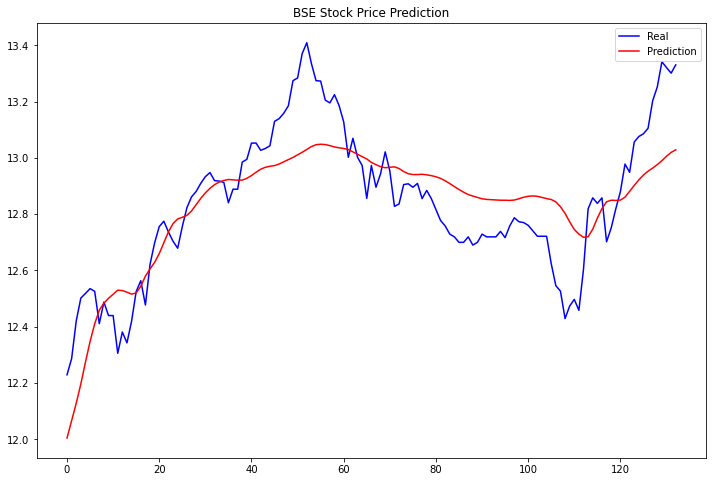

In [35]:
ytest_tr = pd.DataFrame(ytest)
test_predict = pd.DataFrame(test_predict)
plt.figure(figsize=(12,8))
plt.plot(ytest_tr, color='blue', label='Real')
plt.plot(test_predict , color='red', label='Prediction')
plt.title('BSE Stock Price Prediction')
plt.legend()
plt.show()